<a href="https://colab.research.google.com/github/N-nolwenn/RepositoryTest/blob/main/Fall_armyworm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Importing the relevant libraries
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import random
from IPython.display import Image as ShowImage

# Keras libraries
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization,GlobalMaxPooling2D
from tensorflow.keras.applications.vgg16 import VGG16 #16개의 레이어를 제공하는 CNN 아키텍처(사전 훈련된 네트워크로 재사용 가능)
from keras.preprocessing.image import ImageDataGenerator # 실시간 데이터 증식으로 텐서 이미지 데이터의 배치를 생성.(크기 조정, 회전, 확대/축소)
from tensorflow.keras import optimizers
from keras.models import Model

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
from google.colab import files
myfile = files.upload()

Saving Train1.csv to Train1.csv


In [ ]:
# Reading the data
train_labels = pd.read_csv("Train1.csv")
# Show the first 5 rows
train_labels.head()

,Image_id,Label
0,id_02amazy34fgh2.jpg,1
1,id_02mh3w48pmyc9.jpg,0
2,id_02rpb463h9d3w.jpg,0
3,id_02wc3jeeao8ol.jpg,1
4,id_03t2hapb8wz8p.jpg,1


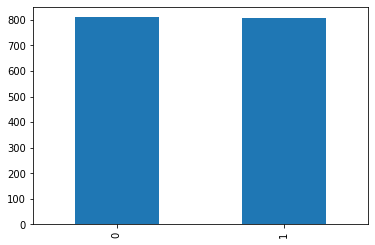

In [ ]:
train_labels['Label'].value_counts().plot.bar()

**가을 거위충에 영향을 받은 옥수수 작물 이미지와 그렇지 않은 이미지 데이터의 수가 비슷**
**--> The number of images of corn crops affected by autumn geese and the number of image data that are not**

In [ ]:
from google.colab import files
myfile = files.upload()

Saving Images.zip to Images.zip


In [ ]:
import zipfile
with zipfile.ZipFile("Images.zip", 'r') as zip_ref:
    zip_ref.extractall("targetdir")

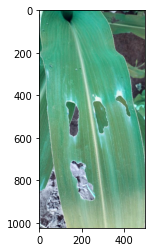

In [ ]:
import cv2
import random
import os

# This stores the location of the data source
data = os.listdir("targetdir")
# Picking random sample from data list
sample = random.choice(data)
# The imread method loads image from the sprcified file
img = cv2.imread("targetdir/"+sample)
# The cmap parameter displays the image in gray
plt.imshow(img, cmap="gray")

In [ ]:
#Replace 0 and 1 with whether they are affected by pests
train_labels["Label"] = train_labels["Label"].replace({0: 'notaffected', 1: 'affected'})

In [ ]:
# Defining how data is passed to the input layer 
image_size = 224
input_shape = (image_size, image_size, 3) #(Image Height, Image Width, Image Channel)
batch_size = 16

In [ ]:
pre_trained_model = VGG16(input_shape=input_shape, include_top=False, weights="imagenet")
# The include_top parameter determines whether to include the output layer, which is false because the output layer of the VGG16 model is not required for our classification problem
# The weights parameter specifies a weight checkpoint to initialize the model
# The input_shape parameter is the size of the image tensor to enter into the network

for layer in pre_trained_model.layers[:15]:
  layer.trainable = False
for layer in pre_trained_model.layers[15:]:
  layer.trainable = True
last_layer = pre_trained_model.get_layer('block5_pool')
last_output = last_layer.output

x = GlobalMaxPooling2D()(last_output) #GlobalMaxPooling2D - Another type of pooling in which the pooling size is set equal to the input size, leading to the maximum value of the entire input being connected to the output value
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(2, activation='softmax')(x)

model = Model(pre_trained_model.input, x)

model.compile(loss='binary_crossentropy', #Binary classification
optimizer=optimizers.SGD(lr=1e-4, momentum=0.9), #stochastic gradient descent
metrics=["AUC"]) #Set to Accuracy because it is a classification problem
model.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


1. Input layer - Input layer reads image. The image is displayed in a 3D matrix. Dimensions are height, width, and channel. Width and height are reduced as the network gets deeper.
2. Convolutional layer - Image features such as edges are extracted from within this layer.
3. Pooling layer - This layer reduces image dimension size. The purpose of this layer is to reduce the computational ability when processing data by reducing the image size. This reduces the likelihood of overfitting in the long run (you can see that the image size decreases as it passes through the MaxPooling2D layer)
4. Fully-connected layer - This layer is trained to classify images between different categories, ie nonlinear combinations of high -level features represented by the output of the convolution layer.
5. Output layer - Include final label (0 or 1)

In [ ]:
# Implementation of early termination.
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

earlystop = EarlyStopping(patience=10)
# ReduceLRonPlateau calls back to reduce learning rates when accuracy improvements are interrupted
# The patency parameter is the number of epochs that have not improved since the learning rate has decreased
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',patience=2,verbose=1,factor=0.5,min_lr=0.00001)
callbacks = [earlystop, learning_rate_reduction]

In [ ]:
# train_test_split Using methods to divide training data into training and validation datasets
from sklearn.model_selection import train_test_split

train_df,validate_df=train_test_split(train_labels,test_size=0.2,random_state=42)
train_df = train_df.reset_index(drop='True')
validate_df = validate_df.reset_index(drop='True')

In [ ]:
# Generate batches of tensor image data with real-time data augmentation
from keras.preprocessing.image import ImageDataGenerator, load_img

# Categorical encodes categorical variables 
from tensorflow.keras.utils import to_categorical

In [ ]:
# Here we are formatting the training data 
train_datagen = ImageDataGenerator(rotation_range=15,
                                 rescale=1./255,
                                 shear_range=0.1,
                                 zoom_range=0.2, # zoom range (1-0.2 to 1+0.2)
                                 horizontal_flip=True,
                                 width_shift_range=0.1,
                                 height_shift_range=0.1)

train_generator = train_datagen.flow_from_dataframe(dataframe=train_df,
                                                  directory="targetdir/",
                                                  x_col="Image_id",
                                                  y_col="Label",
                                                  target_size=(image_size,image_size),
                                                  class_mode='categorical',
                                                  batch_size=15)

# Here we are formatting images on the validation data 
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(validate_df,
                                                  directory="targetdir/",
                                                  x_col="Image_id",
                                                  y_col="Label",
                                                  target_size=(image_size,image_size),
                                                  class_mode='categorical',
                                                  batch_size=15)

Found 1295 validated image filenames belonging to 2 classes.
Found 324 validated image filenames belonging to 2 classes.


In [ ]:
#Train the model using the training dataset and run it for 100 epochs
epochs=100 
total_validate = validate_df.shape[0]
total_train = train_df.shape[0]
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # This is added back by InteractiveShellApp.init_path()


Epoch 1/100
80/80 [==============================] - 50s 444ms/step - loss: 0.7891 - auc: 0.5599 - val_loss: 0.6265 - val_auc: 0.8024 - lr: 1.0000e-04
Epoch 2/100
80/80 [==============================] - 36s 447ms/step - loss: 0.6727 - auc: 0.7066 - val_loss: 0.5425 - val_auc: 0.8972 - lr: 1.0000e-04
Epoch 3/100
80/80 [==============================] - 34s 427ms/step - loss: 0.5546 - auc: 0.8457 - val_loss: 0.4486 - val_auc: 0.9268 - lr: 1.0000e-04
Epoch 4/100
80/80 [==============================] - 34s 424ms/step - loss: 0.4460 - auc: 0.9184 - val_loss: 0.3222 - val_auc: 0.9744 - lr: 1.0000e-04
Epoch 5/100
80/80 [==============================] - 34s 431ms/step - loss: 0.3228 - auc: 0.9639 - val_loss: 0.2114 - val_auc: 0.9921 - lr: 1.0000e-04
Epoch 6/100
80/80 [==============================] - 35s 432ms/step - loss: 0.2284 - auc: 0.9833 - val_loss: 0.1463 - val_auc: 0.9956 - lr: 1.0000e-04
Epoch 7/100
80/80 [==============================] - 35s 430ms/step - loss: 0.1676 - auc: 0.99

In [ ]:
from google.colab import files
myfile = files.upload()

Saving Test1.csv to Test1.csv


In [ ]:
# Reading the data
test_labels = pd.read_csv("Test1.csv")
# Show the first 5 rows
test_labels.head()

,Image_id
0,id_00exusbkgzw1b.jpg
1,id_03dqinf6w0znv.jpg
2,id_046yl0cxn3ybz.jpg
3,id_04athdtx2abyg.jpg
4,id_062aauf9e9jk0.jpg


In [ ]:
for i in data:
    flag=0
    for j in df["image"]:
        if(i==j):
            flag=1
            break;
        else:
            continue
    if(flag==0):    
       target.append(i)

In [ ]:
#Finally, pass the test data to the ImageDataGenerator to fit the model to the test data
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_labels, 
    directory="targetdir/",
    x_col="Image_id",
    y_col="Label",
    target_size=(image_size,image_size),
    class_mode='categorical',
    batch_size=15,
    shuffle=False)
nb_samples = test.shape[0]
#The model.predict_generator helps predict new image data.
#The np.ceil method raises the result value of nb_samples/batch_size
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

KeyError: ignored

In [ ]:
# Here we are converting the submission data to a dataframe
# Save the predict object that stores the predicted results above in the target row of the test dataset.
test["Label"]=predict

#here we are converting to a csv file
test.to_csv("submission.csv",index=False)